In [1]:
import scipy.io
import numpy as np
import scipy.misc
from matplotlib import pyplot as plt
from PIL import Image
from scipy import fftpack, signal
from scipy.linalg import circulant
import sklearn
from sklearn.decomposition import PCA
import sklearn.neighbors
import cv2
import another_ref,nir_ref

/home/bugs/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.ball_tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
IMAGE_PATH = 'DIPSourceHW2.png'
RESULT_PATH = './output/'
SIZE = 256
WHITE_LEVEL = 255
ALPHA = 3

In [3]:
image_tank = cv2.imread('DIPSourceHW2.png', cv2.IMREAD_GRAYSCALE)
image_tank = image_tank / 255.0

In [4]:
## define constants
alpha = 3
window_size = 15
filter_range_sinc = window_size/4  #was window_size/2. smaller range ==> wider gaussian,
filter_range_gaussian = window_size / 16
mu = 0
sigma = 1
iter_num = 15

In [11]:
# create PSFs
s_psf = another_ref.sinc_psf(100)
# 0.1 or 1 std might be better
g_psf = another_ref.gaussian_psf(size=16, std=1.)

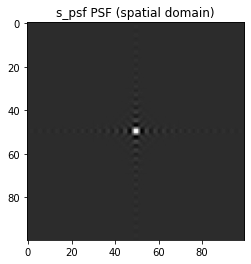

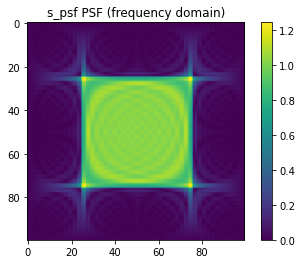

In [12]:
plt.imshow(s_psf, cmap='gray')
plt.title(f's_psf PSF (spatial domain)')
plt.show()
psf_dft = fftpack.fftshift(fftpack.fft2(s_psf))
plt.title(f's_psf PSF (frequency domain)')
plt.imshow(np.abs(psf_dft))
plt.colorbar()
plt.show()

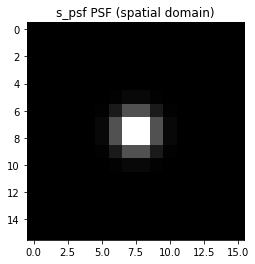

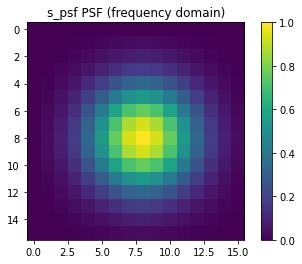

In [13]:
plt.imshow(g_psf, cmap='gray')
plt.title(f's_psf PSF (spatial domain)')
plt.show()
psf_dft = fftpack.fftshift(fftpack.fft2(g_psf))
plt.title(f's_psf PSF (frequency domain)')
plt.imshow(np.abs(psf_dft))
plt.colorbar()
plt.show()

In [14]:
original_img_size = (image_tank.shape[1], image_tank.shape[0])
new_img_size = (int(image_tank.shape[1]/alpha),int(image_tank.shape[0]/alpha))

In [15]:
# use gaussian PSF to create downsampled and upsampled images
blurred_image_gaussian = signal.convolve2d(image_tank, g_psf, mode='same', boundary='wrap')
downsampled_image_gaussian = cv2.resize(blurred_image_gaussian, new_img_size, interpolation=cv2.INTER_NEAREST)
upsampled_image_gaussian = cv2.resize(downsampled_image_gaussian, original_img_size, interpolation=cv2.INTER_CUBIC)

In [16]:
# use sinc PSF to create downsampled and upsampled images
blurred_image_sinc = signal.convolve2d(image_tank, s_psf, mode='same', boundary='wrap')
downsampled_image_sinc = cv2.resize(blurred_image_sinc, new_img_size, interpolation=cv2.INTER_NEAREST)
upsampled_image_sinc = cv2.resize(downsampled_image_sinc, original_img_size, interpolation=cv2.INTER_CUBIC)

In [17]:
# compute k by each PSF
k_gaussian = another_ref.compute_k(downsampled_image_gaussian, alpha, iter_num)
k_sinc = another_ref.compute_k(downsampled_image_sinc, alpha, iter_num)

mean: 0.005680528729723567 std: 0.04926759516296965
mean: 0.006508296186827794 std: 0.05062565288089406
mean: 0.0069930601613501465 std: 0.05152175458102119
mean: 0.007240865759122275 std: 0.051982762600403375
mean: 0.007353508704880104 std: 0.052387233133562944
mean: 0.007396843411175698 std: 0.052879845684996304
mean: 0.007407054396260485 std: 0.053452029923567845
mean: 0.007404940491735819 std: 0.05401979036226329
mean: 0.007397069972530358 std: 0.054610736959506925
mean: 0.0073855746322530535 std: 0.0552118302580346
mean: 0.0073722045075206525 std: 0.05580966598204504
mean: 0.0073584039480647494 std: 0.056402453339645976
mean: 0.007345437839838762 std: 0.05695680416668267
mean: 0.007333633969350962 std: 0.05746357023273139
mean: 0.0073229643879202735 std: 0.05793667906566456
mean: 0.005569981223983049 std: 0.047715113690632846
mean: 0.006299883665748306 std: 0.04743693803311835
mean: 0.006765427112947751 std: 0.04784656609106993
mean: 0.007031287394349211 std: 0.048337823861500685


In [18]:
# restore with wiener filter for each k for each PSF
restored_gaussian_with_gaussian = another_ref.wiener_filter(upsampled_image_gaussian, k_gaussian)
restored_gaussian_with_sinc = another_ref.wiener_filter(upsampled_image_gaussian, k_sinc)
restored_sinc_with_sinc = another_ref.wiener_filter(upsampled_image_sinc, k_sinc)
restored_sinc_with_gaussian = another_ref.wiener_filter(upsampled_image_sinc, k_gaussian)

In [19]:
# restore with wiener filter for the true kernel
restored_gaussian_with_true_kernel = another_ref.wiener_filter(upsampled_image_sinc, g_psf)
restored_sinc_with_true_kernel = another_ref.wiener_filter(upsampled_image_gaussian, s_psf)

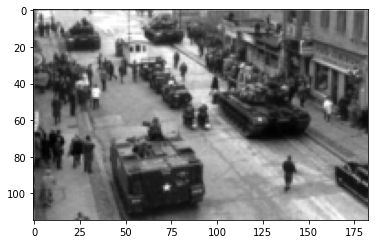

In [23]:
# store low res images
plt.imshow(downsampled_image_gaussian, cmap='gray')
plt.show()


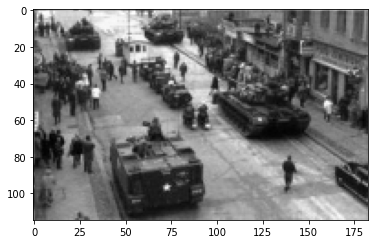

In [24]:
plt.imshow(downsampled_image_sinc, cmap='gray')
plt.show()

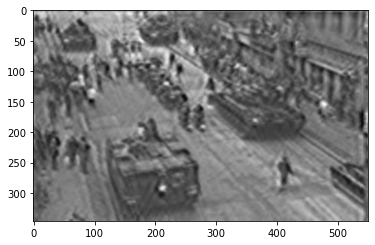

In [25]:
# store results and compute PSNR
plt.imshow(restored_gaussian_with_gaussian, cmap='gray')
plt.show()

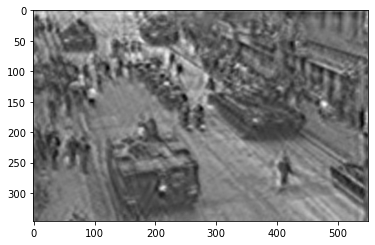

In [26]:
plt.imshow(restored_gaussian_with_sinc, cmap='gray')
plt.show()

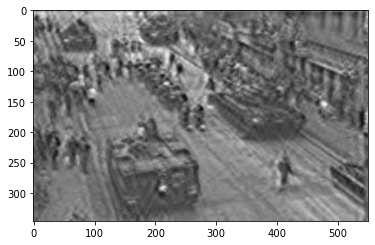

In [27]:
plt.imshow(restored_sinc_with_sinc, cmap='gray')
plt.show()

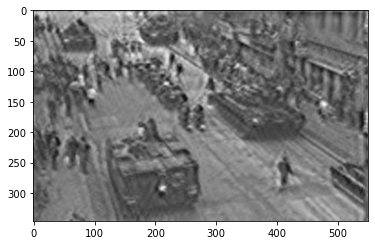

In [29]:
plt.imshow(restored_sinc_with_gaussian, cmap='gray')
plt.show()

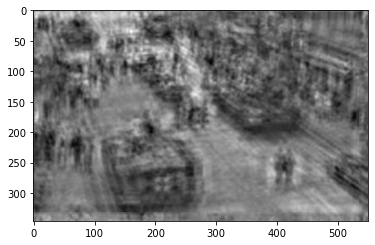

In [30]:
plt.imshow(restored_gaussian_with_true_kernel, cmap='gray')
plt.show()

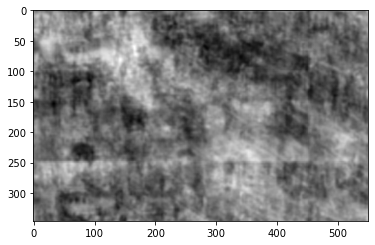

In [31]:
plt.imshow(restored_sinc_with_true_kernel, cmap='gray')
plt.show()

In [32]:
print("PSNR for gaussian on gaussian: {}".format(nir_ref.calculate_psnr(restored_gaussian_with_gaussian,image_tank)))
print("PSNR for sinc on gaussian: {}".format(nir_ref.calculate_psnr(restored_gaussian_with_sinc,image_tank)))
print("PSNR for sinc on sinc: {}".format(nir_ref.calculate_psnr(restored_sinc_with_sinc,image_tank)))
print("PSNR for gaussian on sinc: {}".format(nir_ref.calculate_psnr(restored_sinc_with_gaussian,image_tank)))

PSNR for gaussian on gaussian: 11.075621026477245
PSNR for sinc on gaussian: 11.3666997650384
PSNR for sinc on sinc: 11.757542146574394
PSNR for gaussian on sinc: 11.543729495233697
